<a href="https://colab.research.google.com/github/mons-trev/Generative_AI_research/blob/main/diffusion_xai_paper/diffusion_xai_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install captum

  Using cached captum-0.7.0-py3-none-any.whl (1.3 MB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/xai"

Mounted at /content/drive
/content/drive/My Drive/xai


# Call Imagenet1000 for index



In [ ]:
!wget -P "/content/drive/My Drive/xai" https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2024-06-21 04:15:31--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.24.142, 52.217.72.118, 16.182.75.8, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.24.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘/content/drive/My Drive/xai/imagenet_class_index.json.22’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.03s   

2024-06-21 04:15:32 (1.32 MB/s) - ‘/content/drive/My Drive/xai/imagenet_class_index.json.22’ saved [35363/35363]



In [ ]:
import json
labels_path = '/content/drive/My Drive/xai/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

idx_to_labels

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

# Import

In [ ]:
# Initial imports
import numpy as np
import torch

import torchvision
from torchvision import models
from torchvision import transforms

from captum.attr import IntegratedGradients, GradientShap, Occlusion, LayerGradCam
from captum.attr import visualization as viz
from captum.attr import NoiseTunnel

import captum.attr as cattr

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

import os

# Preprocessing image data, time step, noise scheduling

In [ ]:

transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

In [ ]:
timesteps = 100
time_bar = 1 - np.linspace(0, 1.0, timesteps)

In [ ]:
def forward_noise(x, t):
    a = time_bar[t]
    noise = torch.randn_like(x)
    a = a.reshape(-1, 1, 1, 1)
    img_a = x * (1 - a) + noise * a
    return torch.tensor(img_a)

In [ ]:
def show_examples2(x):
    x = x.cpu().detach().numpy()
    x = (x - x.min()) / (x.max() - x.min())
    plt.figure(figsize=(50, 10))
    for i in range(100):
        plt.subplot(5, 20, i+1)
        plt.imshow(np.transpose(x[i], (1, 2, 0)))
        plt.axis('off')
    plt.show()

# XAI main function

In [ ]:
def func(image_path, TARGET_LABEL_IDX, file_name) :
    # make 100 step noised image
    img = Image.open(image_path)
    transformed_img = transform(img)
    input = transform_normalize(transformed_img)
    input = input.unsqueeze(0)

    t = torch.arange(100)
    a= forward_noise(input, t)
    show_examples2(a)

    model = models.resnet18(pretrained=True)
    model = model.eval()

    predicted_classes = []
    current_class = None
    current_start_idx = 0

    # predict when model starts to recognize class
    for i, image in enumerate(a):
        image = image.unsqueeze(0).to(dtype=torch.float32)

        with torch.no_grad():
            outputs = model(image)
            _, predicted = outputs.max(1)
            predicted_class_idx = str(predicted.item())
            predicted_class = idx_to_labels[predicted_class_idx][1]

        if predicted_class == current_class:
            continue
        else:
            if current_class is not None:
                end_idx = i - 1
                predicted_classes.append((current_start_idx, end_idx, current_class))
            current_class = predicted_class
            current_start_idx = i

    if current_class is not None:
        predicted_classes.append((current_start_idx, len(a) - 1, current_class))

    for start_idx, end_idx, predicted_class in predicted_classes:
        if start_idx == end_idx:
            print(f"Image {start_idx}: {predicted_class}")
        else:
            print(f"Image {start_idx}~{end_idx}: {predicted_class}")

    output_dir = f'/content/drive/MyDrive/xai_resnet_cat/result/{file_name}'
    os.makedirs(output_dir, exist_ok=True)

    # XAI

    # Integrated gradient
    fig, axes = plt.subplots(10, 10, figsize=(40, 40))

    for i in range(len(a)):
        row = i // 10
        col = i % 10
        pickone = a[i].unsqueeze(0)
        ZERO = torch.zeros(pickone.shape)
        ig = IntegratedGradients(model)
        attributions_ig = ig.attribute(pickone.to(dtype=torch.float32),
                                    target=TARGET_LABEL_IDX,
                                    n_steps=20,
                                    baselines=ZERO)
        attributions_ig = np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
        input_img = np.transpose(pickone.squeeze().cpu().detach().numpy(), (1, 2, 0))


        viz.visualize_image_attr(attributions_ig,
                                input_img,
                                method="blended_heat_map",
                                cmap="Reds",
                                show_colorbar=True,
                                sign="positive",
                                outlier_perc=5,
                                plt_fig_axis=(fig, axes[row, col]))

        axes[row, col].axis('off')


    plt.tight_layout()

    plt.show()

    fig.savefig(os.path.join(output_dir, 'IG_output_combined.png'), bbox_inches='tight', pad_inches=0.1)
    plt.show()


    print("done IG")

    # Grad SHAP
    explainer = cattr.GradientShap(model)

    fig, axes = plt.subplots(10, 10, figsize=(40, 40))

    for i in range(len(a)):
        row = i // 10
        col = i % 10
        pickone = a[i].unsqueeze(0)

        baselines = torch.zeros_like(pickone, dtype=torch.float32)

        attributions_gs = explainer.attribute(pickone.to(dtype=torch.float32),
                                              baselines=baselines,
                                              n_samples=10,
                                              stdevs=0.1,
                                              target=TARGET_LABEL_IDX)

        attributions_gs = np.transpose(attributions_gs.squeeze().cpu().detach().numpy(), (1, 2, 0))
        input_img = np.transpose(pickone.squeeze().cpu().detach().numpy(), (1, 2, 0))

        plt_img = viz.visualize_image_attr(attributions_gs,
                                           input_img,
                                           method="blended_heat_map",
                                           cmap="Reds",
                                           show_colorbar=True,
                                           sign="positive",
                                           outlier_perc=5,
                                           plt_fig_axis=(fig, axes[row, col])
                                           )

        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

    fig.savefig(os.path.join(output_dir, 'GS_output_combined.png'), bbox_inches='tight', pad_inches=0.1)
    plt.show()

    print("done GS")


    # Occlusion

    num_images = len(a)
    rows = int(np.sqrt(num_images))
    cols = (num_images + rows - 1) // rows

    fig, axes = plt.subplots(rows, cols, figsize=(40, 40))

    for i in range(num_images):
        row = i // cols
        col = i % cols
        pickone = a[i].unsqueeze(0)
        ZERO = torch.zeros(pickone.shape)

        oc = Occlusion(model)
        attributions_occ = oc.attribute(pickone.to(dtype=torch.float32),
                                        sliding_window_shapes=(3, 15, 15),
                                        strides=(3, 8, 8),
                                        target=TARGET_LABEL_IDX,
                                        baselines=0)

        input_img = np.transpose(pickone.squeeze().cpu().detach().numpy(), (1, 2, 0))
        attributions_occ = np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1, 2, 0))

        viz.visualize_image_attr(attributions_occ,
                                 input_img,
                                 method="blended_heat_map",
                                 cmap="Reds",
                                 show_colorbar=True,
                                 sign="positive",
                                 outlier_perc=5,
                                 plt_fig_axis=(fig, axes[row, col]))

        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

    fig.savefig(os.path.join(output_dir, 'OC_output_combined.png'), bbox_inches='tight', pad_inches=0.1)
    plt.show()

    print("done OC")


<ipython-input-10-a4429e0a31cb>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img_a)


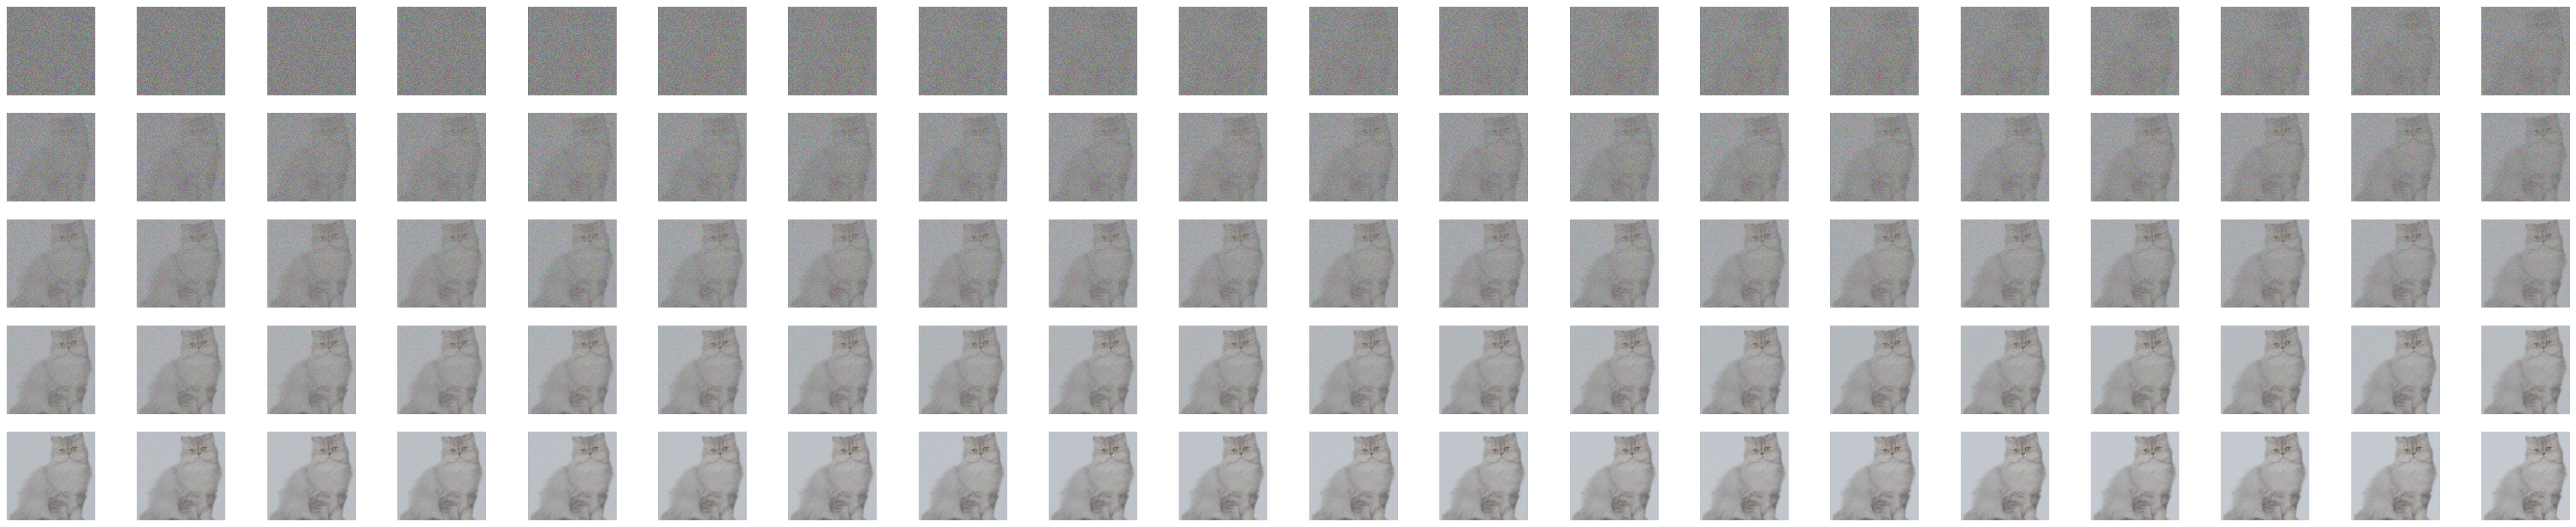

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 89.9MB/s]


Image 0~19: jellyfish
Image 20~28: syringe
Image 29~40: poncho
Image 41~46: ant
Image 47~49: Arctic_fox
Image 50~99: Persian_cat


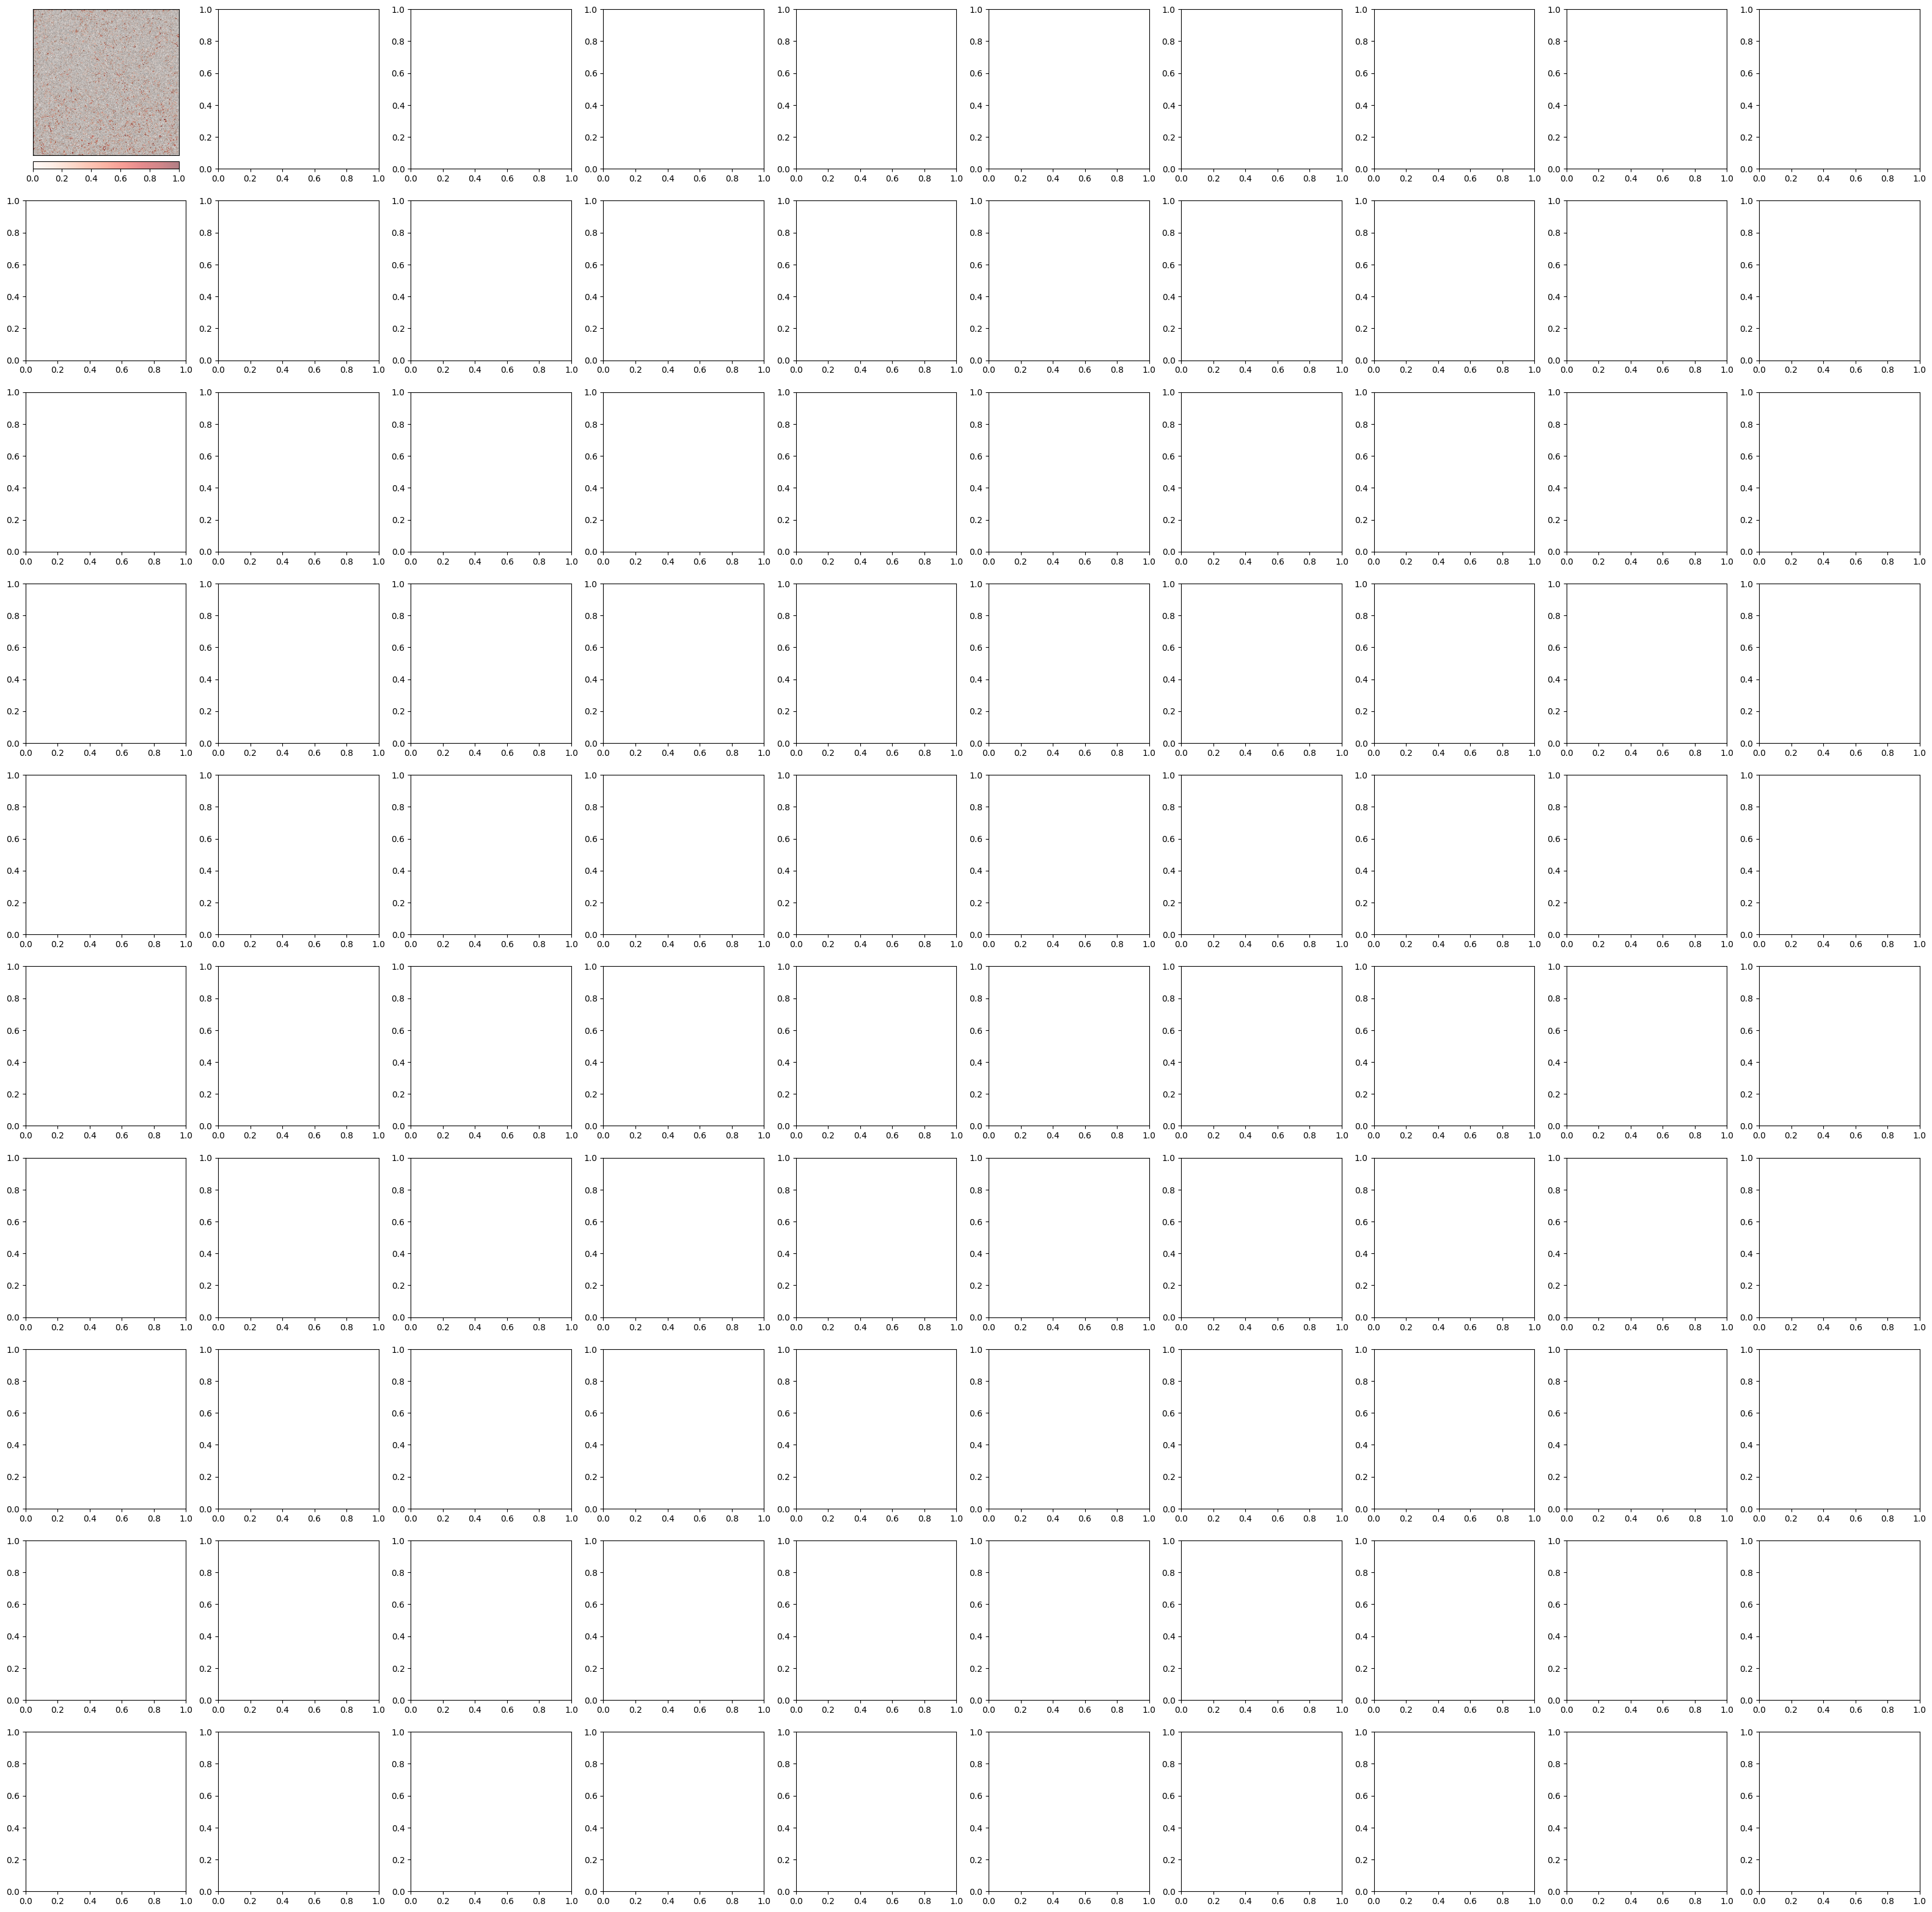

KeyboardInterrupt: 

In [ ]:
# 함수를 호출하는 부분은 시간이 너무 오래걸리는 관계로 xai plot 은 미리 출력된 결과를 촬영하도록 하겠습니다.
func('/content/drive/MyDrive/xai_resnet_cat/data/persian.jpg', 283, 'persian')

In [ ]:
func('/content/drive/My Drive/xai_resnet_cat/data/sham.jpg', 284, 'sham')

<ipython-input-10-a4429e0a31cb>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img_a)


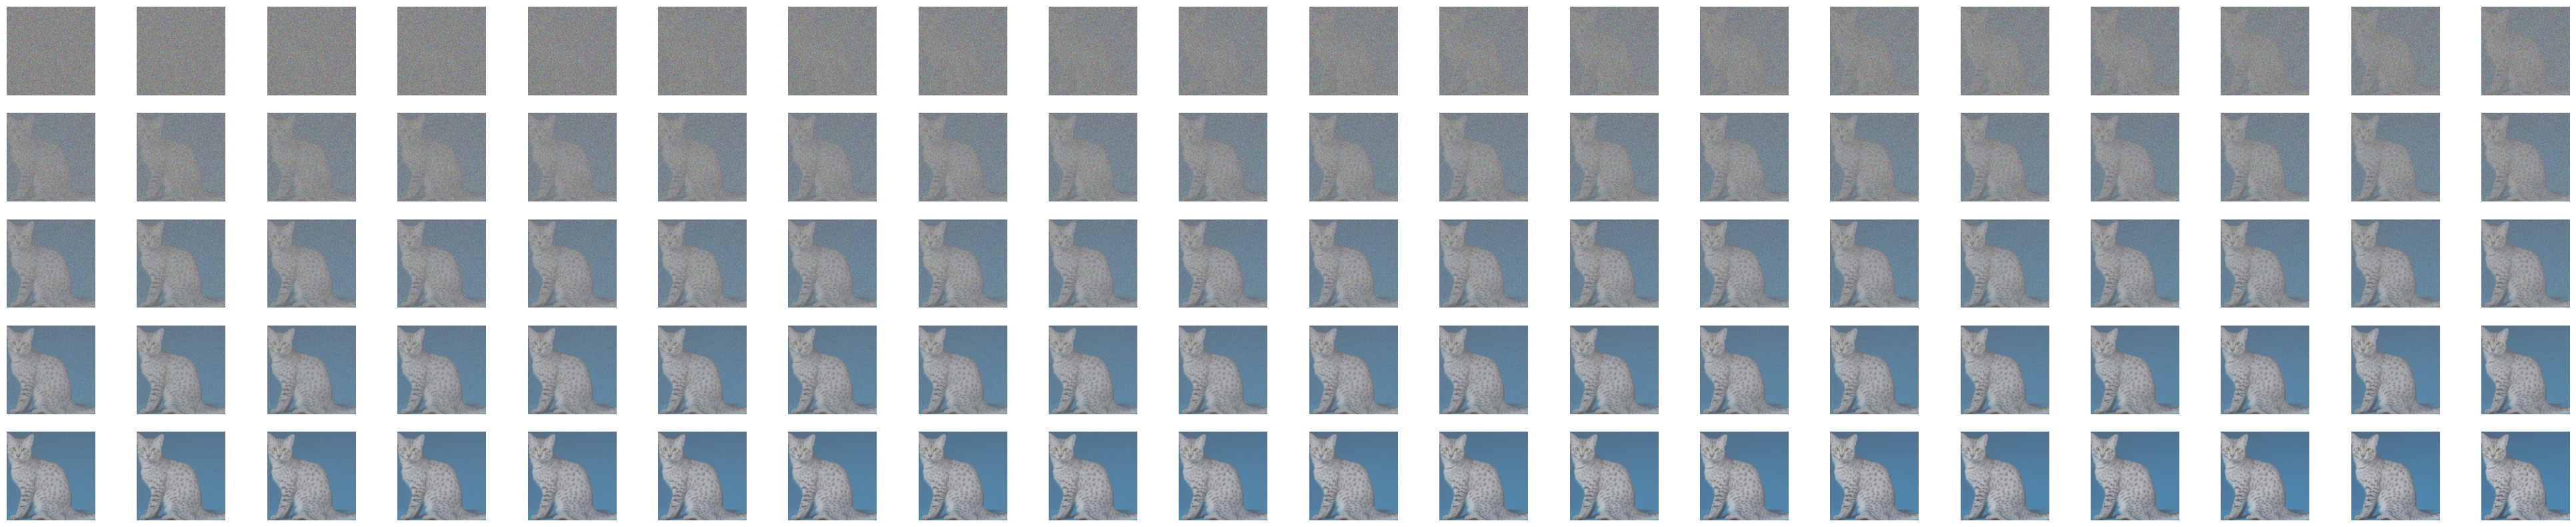

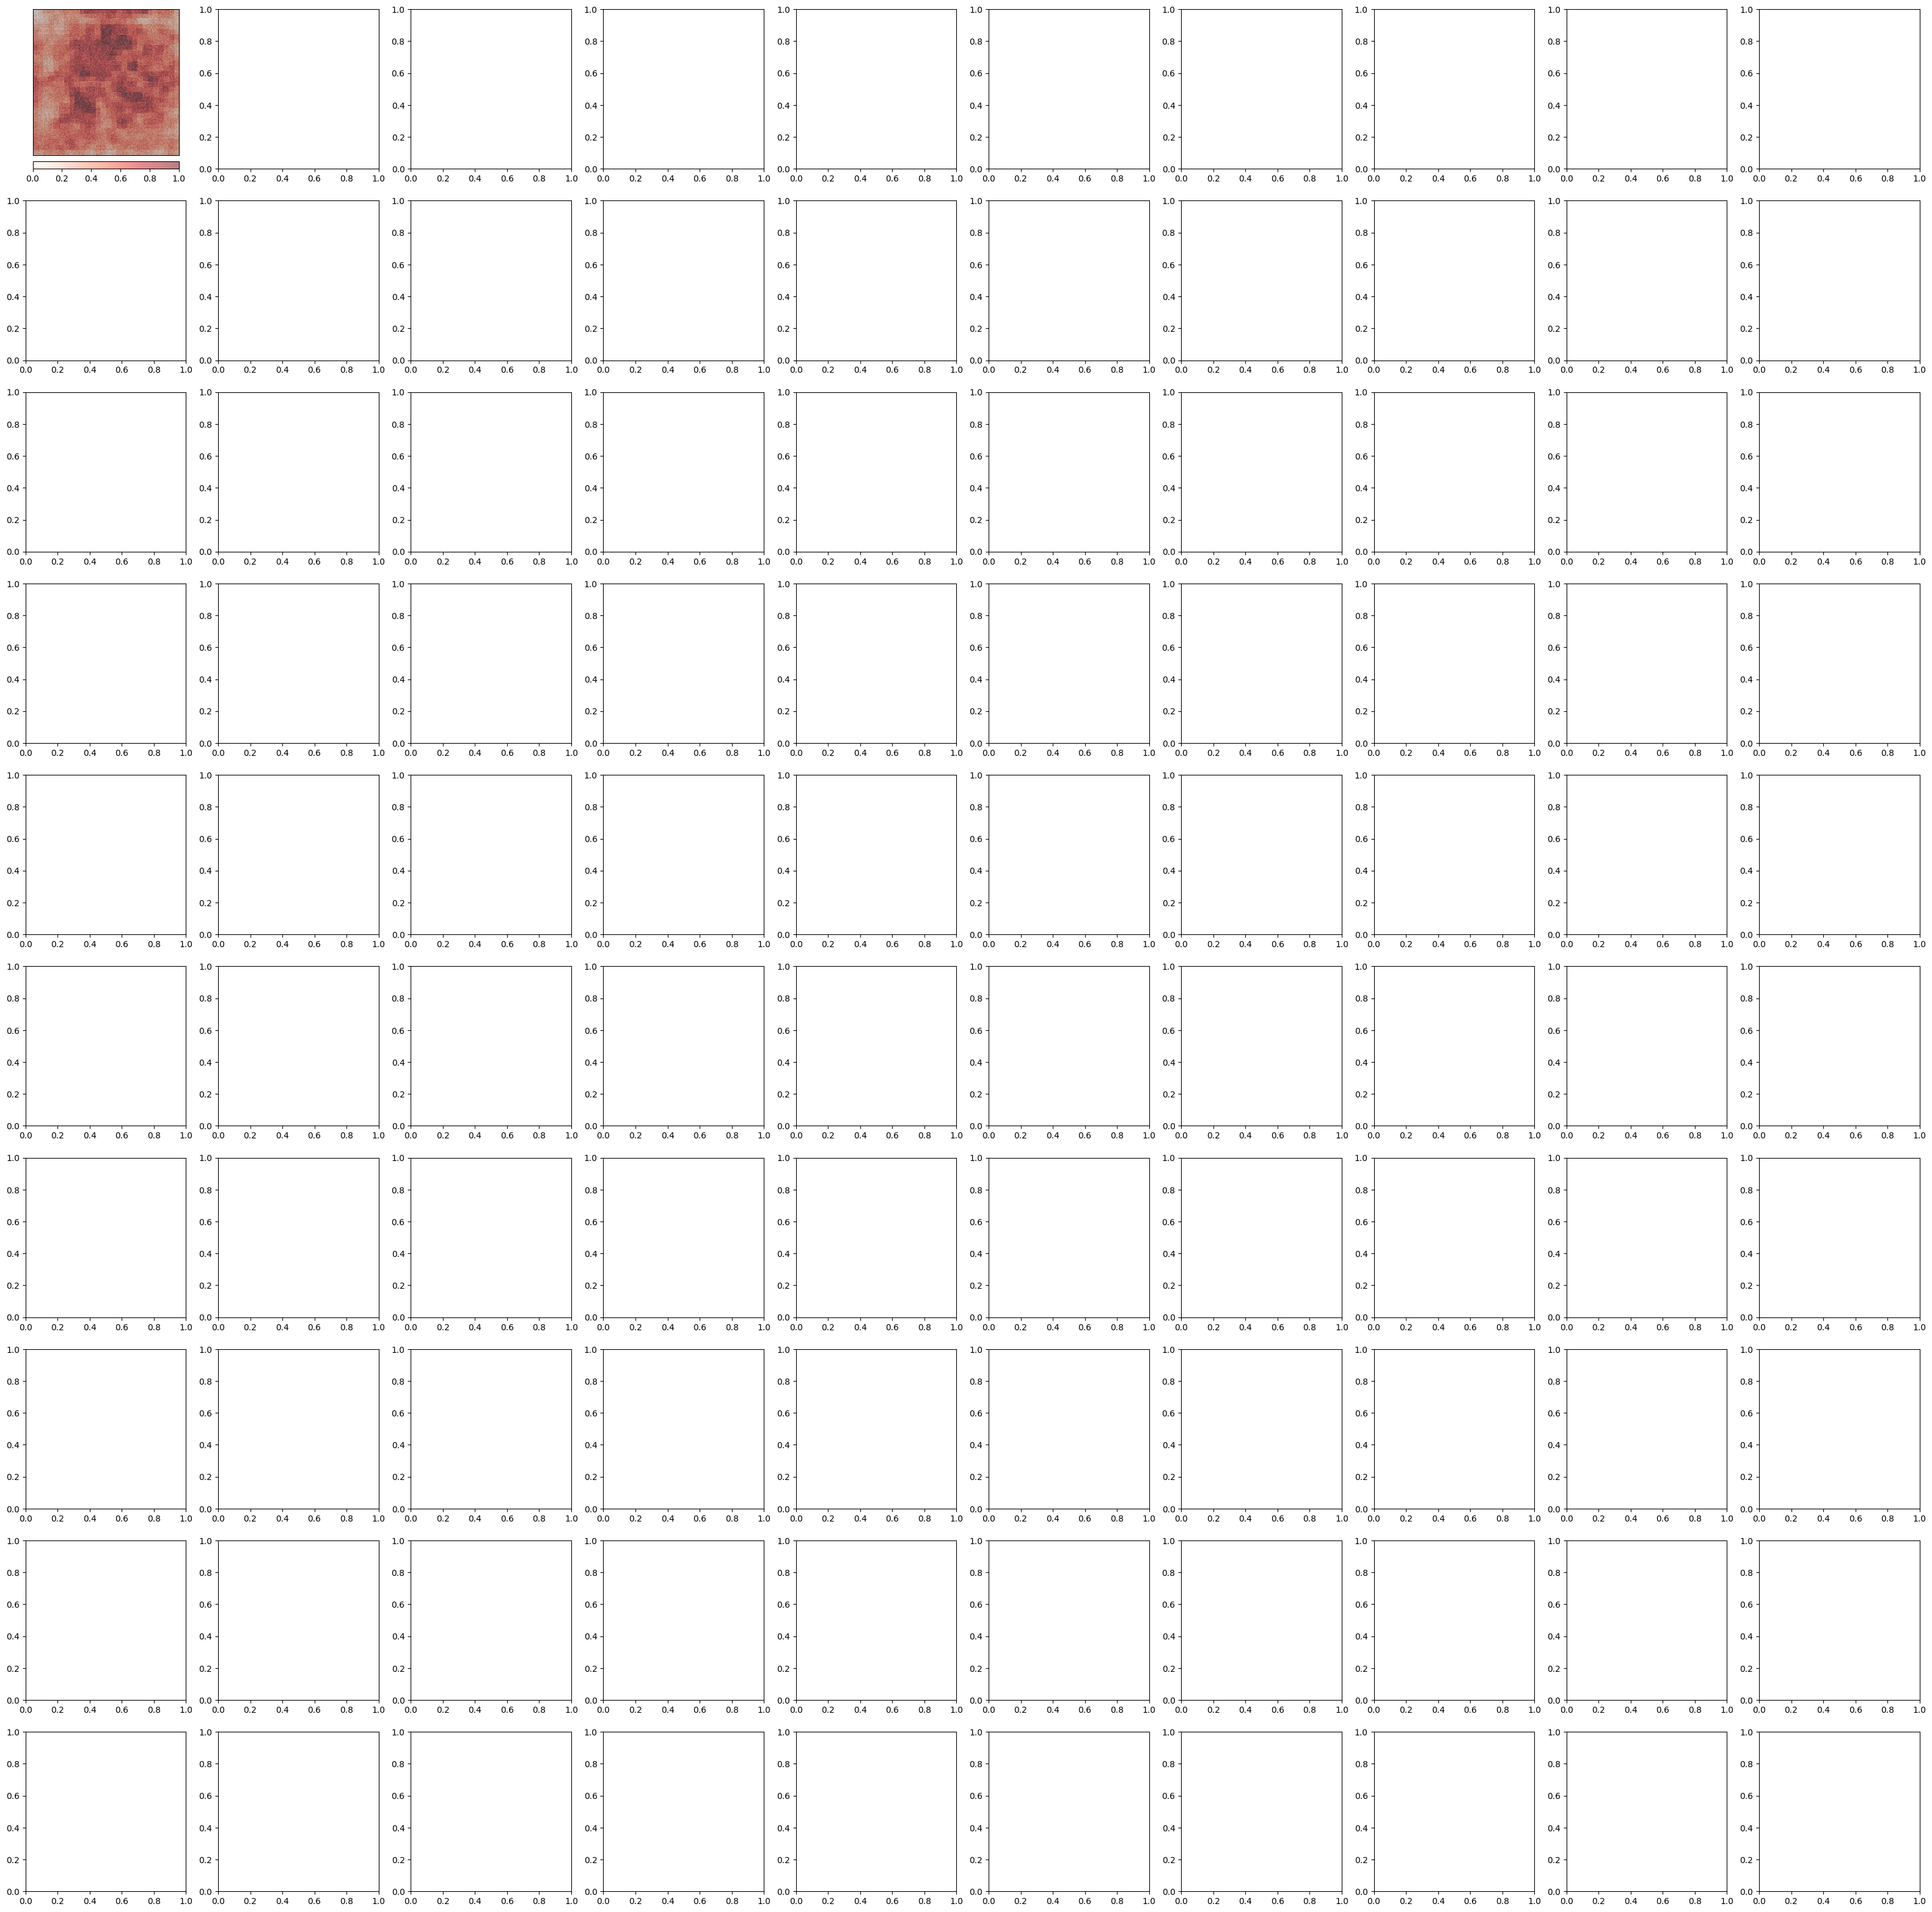

<Figure size 640x480 with 0 Axes>

done OC


In [ ]:
func('/content/drive/MyDrive/xai_resnet_cat/data/egyptian_cat.png', 285, 'egyptian_cat')

In [ ]:
func('/content/drive/MyDrive/xai_resnet_cat/data/tiger.jpg', 285, 'tiger')

# Likelihood graph

<ipython-input-10-a4429e0a31cb>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img_a)


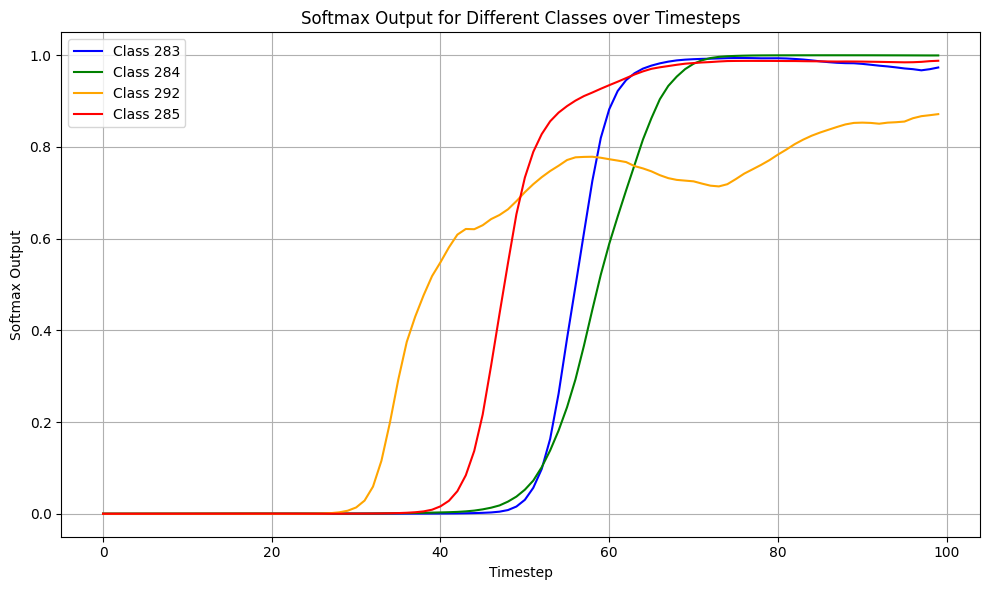

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

model = models.resnet18(pretrained=True)
model.eval()

image_paths = [
    '/content/drive/MyDrive/xai_resnet_cat/data/persian.jpg',
    '/content/drive/MyDrive/xai_resnet_cat/data/sham.jpg',
    '/content/drive/MyDrive/xai_resnet_cat/data/tiger.jpg',
    '/content/drive/MyDrive/xai_resnet_cat/data/egyptian_cat.png'
]

class_indices = [283, 284, 292, 285]

softmax_outputs = [[] for _ in range(len(class_indices))]

for class_idx, image_path in zip(class_indices, image_paths):

    img = Image.open(image_path)
    transformed_img = transform(img)
    input = transform_normalize(transformed_img)
    input = input.unsqueeze(0)

    t = torch.arange(100)
    a= forward_noise(input, t)

    for i in a:
        img =i.unsqueeze(0).to(dtype=torch.float32)

        with torch.no_grad():
            outputs = model(img)
            softmax = torch.nn.functional.softmax(outputs, dim=1)
            softmax_outputs[class_indices.index(class_idx)].append(softmax[0][class_idx].item())

plt.figure(figsize=(10, 6))

colors = ['blue', 'green', 'orange', 'red']
for i, class_idx in enumerate(class_indices):
    plt.plot(range(100), softmax_outputs[i], label=f'Class {class_idx}', color=colors[i])

plt.xlabel('Timestep')
plt.ylabel('Softmax Output')
plt.title('Softmax Output for Different Classes over Timesteps')
plt.legend()
plt.grid(True)
plt.tight_layout()

save_dir = '/content/drive/MyDrive/xai_resnet_cat/result'
os.makedirs(save_dir, exist_ok=True)


save_path = os.path.join(save_dir, 'softmax_plot.png')
plt.savefig(save_path)

plt.show()
